** *
# Microsoft Malware Classification Challenge (BIG 2015)

---


https://www.kaggle.com/c/malware-classification/


# Initial Setup

## Download Dataset

In [0]:
!pip install kaggle

In [4]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

if not os.path.exists('data/'):

    auth.authenticate_user()

    drive_service = build('drive', 'v3')
    results = drive_service.files().list(
            q="name = 'kaggle.json'", fields="files(id)").execute()
    kaggle_api_key = results.get('files', [])

    filename = "/content/.kaggle/kaggle.json"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    os.chmod(filename, 600)

    !kaggle competitions download -c malware-classification -p data/
    
else:
    print('Dataset already downloaded!')

Dataset already downloaded!


In [0]:
import os
import re
import glob
from tqdm import tqdm
#from tqdm import tqdm_notebook


import numpy as np
import pandas as pd

import multiprocessing
from multiprocessing.dummy import Pool

In [0]:
seed=42
np.random.seed(seed)

In [5]:
cpu_count  = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 3


In [0]:
!cd data && p7zip -d train.7z

# Extract Features

In [0]:
def getOpcodes(file2path):

    openfile = io.open(file2path,'r',encoding='latin-1')
    lines=openfile.readlines()

    opcodes_lst = []

    for line in lines:
        opcode_group = re.search('\s\s\s[a-z][a-z]+\s\s\s',line)
        if opcode_group:
            opcode = opcode_group.group().strip()
            opcodes_lst.append(opcode)
            pass
            
    return opcodes_lst, file2path

In [0]:
def extractInParallel(path_lst, threads=2):
    p = Pool(threads)
    opcodes_lst = []
    file_lst = []
    for opcode, file in tqdm((p.imap_unordered(getOpcodes, path_lst)), total=len(path_lst)):
        opcodes_lst.append(opcode)
        file_lst.append(file)
        pass
    p.close()
    p.join()
    return opcodes_lst, file_lst

In [0]:
def process_targets(trainLabels, y):
  
    target_lst = []
    for file in y:
        f = file.split('/')[-1][:-4]
        target_lst.append(int(trainLabels[trainLabels['Id'] == f]['Class']))
          
    return target_lst

In [0]:
def extractFeatures(path2data, trainLabels, format_file = '*.asm'):
  
    for subdir, dirs, files in os.walk(path2data):
          print('Reading files from dir: {}'.format(subdir))
          path_folder = os.path.join(subdir, format_file)
          filesPath = glob.glob(path_folder) 
          print('Extractig features from: {} files'.format(len(filesPath)))
          opcodes_lst, file_lst =  extractInParallel(filesPath, threads=cpu_count)
          
          y = process_targets(trainLabels, file_lst)
          print('\nDone!')

    return np.array(opcodes_lst), np.array(y)

In [0]:
trainLabels = pd.read_csv('data/trainLabels.csv')

In [8]:
trainLabels.head()

,Id,Class
0,01kcPWA9K2BOxQeS5Rju,1
1,04EjIdbPV5e1XroFOpiN,1
2,05EeG39MTRrI6VY21DPd,1
3,05rJTUWYAKNegBk2wE8X,1
4,0AnoOZDNbPXIr2MRBSCJ,1


In [0]:
path2train = 'data/train'
X, y = extractFeatures(path2train, trainLabels)

In [0]:
print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

##  Dataset Analysis

In [0]:
import matplotlib.pyplot as plt

Text(0.5,0,'#ocorrences')

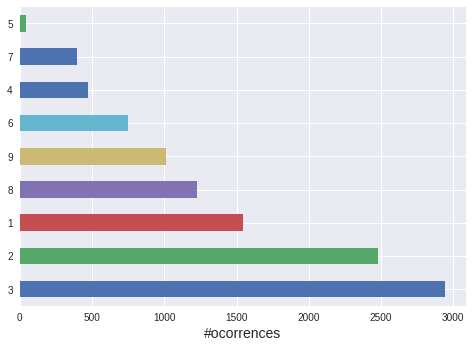

In [10]:
trainLabels['Class'].value_counts().plot(kind = 'barh')
plt.xlabel('#ocorrences', fontsize=14)

## Split train and valid set

In [0]:
from sklearn.model_selection import train_test_split

In [66]:
test_size = 0.2
print('Test size: {}'.format(test_size))
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=42)

Test size: 0.2


In [67]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))

print('X_valid shape: {}'.format(X_valid.shape))
print('y_valid shape: {}'.format(y_valid.shape))

X_train shape: (101,)
y_train shape: (101,)
X_valid shape: (26,)
y_valid shape: (26,)


## Saving processed data

In [0]:
def save_data(X, y, file, path2save):

    os.makedirs(path2save)
    
    data ={'X':X, 'y':y}
    np.savez(path2save + file + ".npz",**data)

    print('Saved in: {}'.format(path2save))  

In [69]:
path2saveTrain = 'proc_data/train/'
path2saveValid = 'proc_data/valid/'


if not os.path.exists(path2saveTrain):
    save_data(X_train, y_train,'opcodes', path2saveTrain)
    save_data(X_valid, y_valid,'opcodes', path2saveValid)

else:
    print('Data already processed!')

Saved in: proc_data/train/
Saved in: proc_data/valid/


## N-grams

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [71]:
max_gram = 4
print('Max_grams: {}'.format(max_gram))

Max_grams: 4


In [0]:
def get_n_grams(X, max_gram = 4):
  

    print('Counting ocorrences of words. Ngram-range: {}...'.format(str((1,max_gram))))
    
    vectorizer = CountVectorizer(analyzer = "word",
                                 max_features = 300,
                                 ngram_range=(1,max_gram)) 
    
    features = vectorizer.fit_transform([" ".join(x) for x in X])

    #downscale weights for words using tf–idf: “Term Frequency times Inverse Document Frequency”.
    print('Words downscaling using TF-IDF...')

    tfidf_transformer = TfidfTransformer()
    features = tfidf_transformer.fit_transform(features)
    
    features = features.toarray()
    model_vectorized = vectorizer
    model_tfidf = tfidf_transformer

    return model_vectorized, model_tfidf, features

In [82]:
model_vectorized, model_tfidf, f_train = get_n_grams(X_train)

Counting ocorrences of words. Ngram-range: (1, 4)...
Words downscaling using TF-IDF...


In [0]:
f_valid = model_vectorized.transform([" ".join(x) for x in X_valid])
f_valid = model_tfidf.transform(f_valid)
f_valid = f_valid.toarray()

In [0]:
print('Train features shape: {}'.format(f_train.shape))
print('Valid features shape: {}'.format(f_valid.shape))

# Train classification model

## Tree Ensemble

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
forest = RandomForestClassifier(n_estimators = 100) 
forest = forest.fit( f_train, y_train )

In [0]:
predictions_forest = forest.predict(f_valid)

## Boosting trees

In [0]:
import xgboost as xgb

In [0]:
clf = xgb.XGBClassifier(max_depth=7,
                        n_estimators=200,
                        colsample_bytree=0.8, 
                        subsample=0.8,
                        nthread=10,
                        learning_rate=0.1)

clf.fit(f_train, y_train)

In [0]:
predictions_xgboost = clf.predict_proba(f_valid)

# Performance evaluation


In [0]:
def confusion_matrix(result, y):

    tagset = list(set(y))
    output = np.zeros((len(tagset), len(tagset)), dtype=float)
    
    for predicted, real in zip(result, y):
        output[tagset.index(predicted), tagset.index(real)] += 1

    return output / output.sum(axis=1)[:, None]
     

In [120]:
cm_forest = confusion_matrix(predictions_forest, y_train)
cm_xboost = confusion_matrix(predictions_xgboost, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [0]:
def evaluate_model(cm):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    print('Accuracy: {}'.format(accuracy))
    print('Misclass: {}\n'.format(misclass))

In [0]:
evaluate_model(cm_forest)
evaluate_model(cm_xboost)


In [0]:
def plot_confusion_matrix(cm, title):

    plt.imshow(cm, interpolation='nearest', cmap=None)
    plt.title(title, fontsize=20)
    plt.colorbar()

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plot_confusion_matrix(cm, 'Confusion matrix trainig set (RF)')

plt.subplot(1,2,1)
plot_confusion_matrix(cm, 'Confusion matrix trainig set (XgBoost)')